# Visualisation of post and comments structure

#### 1. Documentation
- <http://madebyideguchi.blogspot.com/2014/01/networkx-working-with-graphs-in-python.html>
- <https://medium.com/@gbrnc28/random-walk-method-page-rank-algorithm-using-networkx-7da8696ecc38>
- <https://spyhce.com/blog/python-networkx-library>
- <https://epidemicsonnetworks.readthedocs.io/en/latest/>
- <https://github.com/mihaigociu/myrepo/blob/master/networkx_presentation.py>

#### 2. Examples
- <>

Libraries

In [2]:
# database management
import sqlite3
import pandas as pd
import numpy as np 
import itertools

# networkx
import networkx as nx
import networkx.algorithms.community as nxcom

# igraph
import igraph
from igraph import Graph

# draw
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns
# scatter plot
from pandas.plotting import scatter_matrix
# technical
import operator
import random as rd
from functools import reduce

from itertools import combinations, permutations
from scipy import stats
from statsmodels.stats import weightstats as stests
sns.set_style('whitegrid')



## 1. Data preparation

In [2]:
# 1. Extracting and preparing the dataset:
conn = sqlite3.connect('Data/obama_election.db')
# 2. Full dataset
df_obama = pd.read_sql('''SELECT author, parent_author
                            FROM Reddit
                            where month = 10''', conn) 
df_obama

,author,parent_author
0,gkiltz,TehSoupNazi
1,thelordofcheese,zabimaru1000
2,IAmABearAMAA,GiantSquidd
3,acm2033,hobofats
4,[deleted],kjay227
...,...,...
222059,cyress_avitus,Kishara
222060,Cum_Box_Hero,Kishara
222061,Obersts001,Kishara
222062,Kishara,Kishara


In [3]:
# 1. Extracting and preparing the dataset:
conn = sqlite3.connect('Data/trump_election.db')
# 2. Full dataset
df_trump = pd.read_sql('''SELECT author, parent_author
                            FROM Reddit
                            where month = 10''', conn) 
df_trump

,author,parent_author
0,JuicyJuuce,Dyna82
1,Dyna82,JuicyJuuce
2,TheLightningbolt,mindbleach
3,mindbleach,TheLightningbolt
4,TheLightningbolt,flippydude
...,...,...
429129,formeraide,myellabella
429130,rafikiknowsdeway1,myellabella
429131,satosaison,myellabella
429132,AutoModerator,myellabella


## 2. Graph creation

In [4]:
def graph_creator(df_in, n_conn):
    #===============================================================================
    # Data
    df = df_in[(~df_in['author'].isin(['[deleted]','None']))  &  (~df_in['parent_author'].isin(['[deleted]','None'])) ]

    #===============================================================================    
    # graph
    G_all=nx.from_pandas_edgelist(df, source='parent_author', target='author', create_using=nx.DiGraph())
    
    # 1) select only bi-directional edges
    selected_edges = []
    for u,v in G_all.edges():
        # check if bi-directional
        if G_all.has_edge(u, v) == G_all.has_edge(v, u):
            selected_edges.append((u,v))         
            
    # undirected graph        
    H = nx.Graph()
    H.add_edges_from(selected_edges)
    
    # 2. keep only nodes that engaed creating a count attribute
    nx.set_edge_attributes(H, 0, "count")
    for source, target in df.itertuples(index=False):
        if H.has_edge(source, target) == True:
            H.edges[source, target]['count'] +=1
            
    # keep only those edges that occurr 3 or more times 
    selected_edges = [(u,v) for u,v,e in H.edges(data=True) if e['count']  >= n_conn]
    G_sub = H.edge_subgraph(selected_edges)
    
    # removing disconnected nodes
    sub_list = max(nx.connected_components(G_sub), key=len)
    G = G_sub.subgraph(sub_list)
    
    
    # position of nodes
    pos = nx.nx_pydot.graphviz_layout(G, prog='sfdp')
    #pos = nx.kamada_kawai_layout(G)
    
    return G, pos

In [5]:
#G, pos = graph_creator(df_obama[['author','parent_author']], n_conn=4)
G, pos  = graph_creator(df_trump[['author','parent_author']], n_conn=5)

In [10]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3329
Number of edges: 3552
Average degree:   2.1340


## 4. Centrality measures

In [ ]:
def centrality_measures(G):

    # 1. Calculate page rank
    pr = pd.DataFrame(list(nx.pagerank(G, alpha=0.8).items()), columns=['id', 'centrality_page_rank']).sort_values(by=['id'], ascending=False)  

    # 2. Calculate eigenvector
    eigenvector = pd.DataFrame(list(nx.eigenvector_centrality_numpy(G).items()), columns=['id', 'centrality_eigenvector']).sort_values(by=['id'], ascending=False)  

    # 3. Calculate degree centrality
    degree = pd.DataFrame(list(nx.degree_centrality(G).items()), columns=['id', 'centrality_degree']).sort_values(by=['id'], ascending=False)  

    # 4. Calculate closeness centrality
    closeness = pd.DataFrame(list(nx.closeness_centrality(G).items()), columns=['id', 'centrality_closeness']).sort_values(by=['id'], ascending=False)  

    # 5. Calculate betweeness centrality
    betweenness  = pd.DataFrame(list(nx.betweenness_centrality(G).items()), columns=['id', 'centrality_betweenness']).sort_values(by=['id'], ascending=False) 
    
    # 6. Calculate Katz centrality
    flow  = pd.DataFrame(list(nx.current_flow_closeness_centrality(G).items()), columns=['id', 'centrality_flow']).sort_values(by=['id'], ascending=False) 
    

    # Merge all together      
    df_final = reduce(lambda left,right: pd.merge(left,right,on='id'), [pr, eigenvector, degree, closeness, betweenness, flow])
    df_final["importance"] = (df_final["centrality_page_rank"]+df_final["centrality_eigenvector"]+df_final["centrality_degree"]+df_final["centrality_closeness"]+df_final["centrality_betweenness"]+df_final["centrality_flow"])/6
    df_final["random"] = df_final.apply(lambda x: np.random.wald(0.5, 0.5, 1)[0], axis=1)
    
    return df_final

In [ ]:
centrality = centrality_measures(G)

In [37]:
def corr_plot(df_in):
    df=df_in.rename(columns={"centrality_page_rank": "page rank", "centrality_closeness": "closeness",
                       "centrality_eigenvector": "eigenvector", "centrality_betweenness": "betweenness",
                       "centrality_flow": "flow", "centrality_degree": "degree"}).drop(columns=["importance","random"])
    corr = df.corr().to_numpy()

    axes = scatter_matrix(df, figsize=(10,6), hist_kwds={'bins':10})
    for subaxis in axes:
        for ax in subaxis:
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

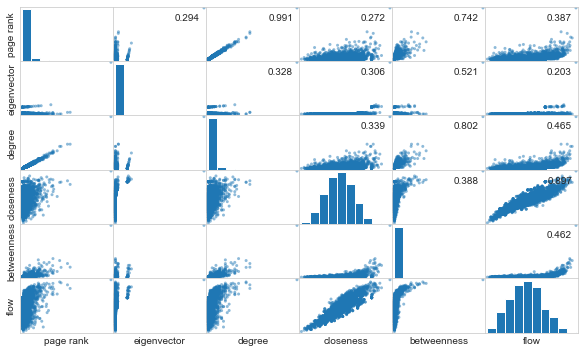

In [38]:
corr_plot(centrality)    
plt.savefig(r'Visualisations/6_2_centrality_corr.png', bbox_inches='tight')
plt.show()

In [ ]:
centrality.to_csv('centrality.csv', index=False) 

## 5. Random walk

In [6]:
def random_walk(G, num_tries, num_iteration):

    """
    The function perfoms random walk over a networkx graph.

    Parameters:
        G (graph object): networkx object
        num_tries (int): number of iterations    
        num_iteration (int): number of hops 

    Returns:
        visit_count (dict): dictionary contatining numberof visits  
    """
    
    #rd.seed(123)
    
    counter = 0
    execution = 0
    visit_count = {}
    while execution <= num_tries:    
        
        visited_nodes = []

        # Choose a random start node
        node_id = rd.sample(list(G.nodes()), 1)[0]    
        
        # Execute  random walk (jumps)
        while counter <=  num_iteration: 

            # create a list of neighbours for node
            neighbour_list = [node for node in G.neighbors(node_id)]
            
            #-------------------------------------------------------------------------------
            # if node has neighbours 
            if len(neighbour_list) > 1:
                                
                #-------------------------------------------------------------------------------
                # move bach to beginning    
                if len(visited_nodes) > 7 and visited_nodes[-6] == visited_nodes[-1]:
                        node_id = visited_nodes[1]
                    
                #-------------------------------------------------------------------------------
                # continue movement
                else:                
                    
                    # Count the number of times each node is visited
                    if node_id in visit_count:
                        visit_count[node_id] += 1
                    else:
                        visit_count[node_id] = 1                

                    # add node to list
                    visited_nodes.append(node_id)

                    # Choose a vertex from the vertex neighborhood to start the next random walk
                    node_id = rd.sample(neighbour_list, 1)[0] 
                
            #-------------------------------------------------------------------------------
            # move back    
            else:
                if len(visited_nodes) > 0:
                    node_id = visited_nodes[-1] 
                else:
                    node_id = rd.sample(list(G.nodes()), 1)[0]   
                    visited_nodes = []
                    counter = 0

            #Iteration counter increment
            counter = counter + 1

        #Restart the cycle
        execution = execution + 1
        counter = 0
    
    return visit_count

In [7]:
df_walk = random_walk(G, num_tries=10000, num_iteration=500)

In [ ]:
def random_walk_plot(G, pos, df_in):
    
    # convert to dataframe
    df = pd.Series(df_in).to_frame().reset_index().rename(columns={"index": "user", 0: "count"})\
                .sort_values("count", ascending = False)
    df['bins'] = np.ceil(df['count']/ 100).astype(int)*100
    df['size'] =  (df['count'] / df['count'].max() * 400) .apply(lambda x: max(x, 100)).astype(int)

    # 1. Creating a list for labels
    label_values=df.sort_values(by=["bins"])["bins"].unique()
    n_cat=len(label_values)
    
    # 3. Node labels and values
    node_param = pd.DataFrame({'user': df["user"], 'parameter': df["bins"], 'size': df["size"] }).set_index('user').reindex(G.nodes()) 

    # 4. Colors    
    my_cmap = ListedColormap(sns.color_palette("Paired", n_colors=n_cat).as_hex())

    # 6. Plot
    fig = plt.figure(figsize=(35, 20))
    
    # draw background
    nx.draw_networkx(G, pos,
                     node_color="grey",  
                     node_size= 70,
                     edge_color="grey", 
                     with_labels=False) 
    
    # draw visited nodes
    nx.draw_networkx(G, pos,
                     node_color = node_param['parameter'],  
                     node_size = node_param['size'],
                     cmap=my_cmap, edge_color="grey",
                     with_labels=False) 

    # 7. Colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap), ticks=[])
    for num, lab in enumerate(label_values):
        cbar.ax.text(.45, 0.5/n_cat +num/n_cat, lab, ha='center', va='center', rotation=270, fontsize=25, color='black') 
    cbar.ax.get_yaxis().labelpad = 20 # how far is the legend title from the colorbar
    cbar.ax.set_ylabel('Number of visits', rotation=270, fontsize=20)


In [ ]:
random_walk_plot(G, pos, df_walk)
plt.savefig(r'Visualisations/6_1_random_walk.png', bbox_inches='tight')
plt.show()

## 6. Conflict simulation

In [ ]:
def conquer_1(neighbor, color_group):
    
    """
    The function calculates the chance of infection.

    Parameters:
        neighbor (str): name of the neighbour node
        color_group (str): color for the group
        
    Returns:
        Boolean: if the infection was sucessful  
    """
    
    # counts
    group = 1
    total = 1
    neighbour_list = [node for node in G.neighbors(neighbor)]
    for elements in neighbour_list:
        if G.nodes[elements]["group"] == color_group:
            group += 1
        total += 1
        
    # random component
    return  bool(np.random.binomial(1, group/total)) 

In [ ]:
def conquer_2(neighbor, color_group, centrality_group):
    
    """
    The function calculates the chance of infection.

    Parameters:
        neighbor (str): name of the neighbour node
        color_group (str): color for the group
        centrality_group (str): name of the centrality measure
        
    Returns:
        Boolean: if the infection was sucessful  
    """
    
    # counts
    group = 1
    total = 1
    neighbour_list = [node for node in G.neighbors(neighbor)]
    for elements in neighbour_list:
        if G.nodes[elements]["group"] == color_group:
            group += G.nodes[elements]['importance']
        total += G.nodes[elements]['importance']
        
    # random component
    return  bool(np.random.binomial(1, group/total)) 

In [ ]:
def node_selection(G, color_group, centrality_group, 
                   neighbour_strategy, conquer_strategy, pct_nodes):
    
    """
    The function iterates through each node and attempts to infect it.

    Parameters:
        G: networkx graph
        color_group (str): color for the group
        centrality_group (str): name of the centrality measure
        neighbour_strategy (int): strategy for neighbour selection 
        conquer_strategy (int):  strategy for conquering nodes
        pct_nodes (int): percentage of nodes to infect
        
    Returns:
        G: networkx graph 
    """
    
    # keep track of each atttempt
    attempts = set()
    
    node_list = [n for n,v in G.nodes(data=True) if v['group'] == color_group] 
    
    # iterate through each node in group
    for elements in node_list:

        # =======================================================================
        # same for all
        if neighbour_strategy == 1:
            sample_list = [node for node in G.neighbors(elements)] 
            rd.shuffle(sample_list)
            
        # =======================================================================
        # different for each group
        if neighbour_strategy == 2:
            neighbours_dict = {}
            for neighbor in G.neighbors(elements):
                if G.nodes[neighbor]['group'] != color_group:
                    neighbours_dict[neighbor] = G.nodes[neighbor][centrality_group]
                    
            sample_list = [k for k, v in sorted(neighbours_dict.items(), key=lambda item: item[1], reverse=True)]

        # =======================================================================
        # if empty - break
        if not sample_list:
            continue
        
        # =======================================================================
        # limit to % of most important ones
        for neighbor in list(itertools.islice(sample_list, max(1, int(len(sample_list) * pct_nodes)))) : 
   
            # an attempt wasn`t already made this turn
            if neighbor in attempts:
                continue
            
            # try to conquer the neighbour   
            if conquer_strategy == 1:
                result = conquer_1(neighbor, color_group)
            if conquer_strategy == 2:
                result = conquer_2(neighbor, color_group, centrality_group)    
            attempts.add(neighbor)
            
            # if sucessful, assign to group
            if result == True:
                G.nodes[neighbor]["group"] = color_group 
    
    return G

In [ ]:
def Simulation(G, node_attributes, # node parameters
               group_list, starting_nodes, # group parameters
               start_strategy, neighbour_strategy, conquer_strategy,  # strategies for selecting nodes 
               n_iter, n_nodes, pct_nodes  # iteration parameters
              ):
    
    """
    The function initialises infected nodes and records changes at each moment of time.

    Parameters:
        G: networkx graph        
        node_attributes (dictionary): dictionary of node properties
        group_list (list): list of tuples containing color and centrality measure
        starting_nodes (list): list of starting nodes               
        start_strategy (int): strategy for selection of starting nodes
        neighbour_strategy (int): strategy for neighbour selection 
        conquer_strategy (int):  strategy for conquering nodes
        pct_nodes (int): percentage of nodes to infect
        n_iter (int): number of iterations
        n_nodes (int): number of starting nodes
        
    Returns:
        G: networkx graph 
        df: dataframe containing information on number of conquered nodes for each group
        initial_colors, step_20_colors, step_100_colors, final_colors (lists): lists containing information on groups at specific time interval
    """
    
    rd.seed(0)
    
    # ==================================================================================
    # 1. Setup:       
    # 1.1 Set default node attributes:
    # a) assign importance
    nx.set_node_attributes(G, node_attributes)
    # b) assign group
    nx.set_node_attributes(G, 'grey', 'group')
    
    # 1.2 Set the starting nodes
    # a) all nodes come from 1 list
    if start_strategy == 1:  
        for color_group, _ in group_list:               
            for nodes in rd.sample(starting_nodes, n_nodes):
                G.nodes[nodes]['group'] = color_group          
    # b) each group has a separate list
    if start_strategy == 2:  
        i=0
        for color_group, _ in group_list:  
            for nodes in rd.sample(starting_nodes[i], n_nodes):
                G.nodes[nodes]['group'] = color_group
            i+=1
                   
    # Make initial snapshots
    initial_colors = []    
    for node in G.nodes():
        initial_colors.append(G.nodes[node]['group'])  
      
    # output dictionary
    change_history = dict( (key, []) for key, value in group_list)
    change_history['time'] = []
    change_history['grey'] = []
    
    #==================================================================================
    # 3. Simulation
    counter = 0
    while counter <= n_iter:        
        
        # 3.1  Conquer nodes
        rd.shuffle(group_list)   
                
        # initialise information spread
        for color_group, centrality_group in group_list:
            # conquer
            G = node_selection(G, color_group, centrality_group, neighbour_strategy, conquer_strategy, pct_nodes)

        # 3.3 output results
        change_history['time'].append(counter)
        change_history['grey'].append(len([n for n,v in G.nodes(data=True) if v['group'] == 'grey']))    
        for color_group, _ in group_list:
            change_history[color_group].append(len([n for n,v in G.nodes(data=True) if v['group'] == color_group]))        

       
        # 3.4 Make snapshots
        # a) at step 20
        if counter == 20:
            # keep track of initially selected nodes
            step_20_colors = []    
            for node in G.nodes():
                step_20_colors.append(G.nodes[node]["group"])      
        # b) at step 20
        if counter == 100:
            # keep track of initially selected nodes
            step_100_colors = []    
            for node in G.nodes():
                step_100_colors.append(G.nodes[node]["group"])
        
        # increase step
        counter +=1        
        
    # Make final snapshots
    final_colors = []    
    for node in G.nodes():
        final_colors.append(G.nodes[node]["group"])
    
    df = pd.DataFrame(change_history)    
        
    return G, df, initial_colors, step_20_colors, step_100_colors, final_colors

In [ ]:
def network_plot(G, pos, initial_colors, step_20_colors, step_100_colors,  final_colors):
    # plot graph        
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    ax = axes.flatten()
    
    # draw graph at step 0
    nx.draw(G, pos, with_labels=False, node_color=initial_colors, node_size= 20, edge_color="grey", ax=ax[0]) 
    ax[0].set_title('Initial location of nodes', fontsize=20)

    # draw graph at step 0
    nx.draw(G, pos, with_labels=False, node_color=step_20_colors, node_size= 20, edge_color="grey", ax=ax[1]) 
    ax[1].set_title('Location of nodes at step 20', fontsize=20)
    
    # draw graph at step 0
    nx.draw(G, pos, with_labels=False, node_color=step_100_colors, node_size= 20, edge_color="grey", ax=ax[2]) 
    ax[2].set_title('Location of nodes at step 100', fontsize=20)
    
    # draw graph 2
    nx.draw(G, pos, with_labels=False, node_color=final_colors, node_size= 20, edge_color="grey", ax=ax[3])
    ax[3].set_title('Final location of nodes', fontsize=20)

In [ ]:
def dynamics_plot(df):
    fig = plt.figure(figsize=(13, 7))
    #plt.ylim(0, 1300)
    #plt.xlim(0, 1000)
    for color_group in color_list:
        plt.plot(df['time'], df[color_group], marker='', color=color_group, linewidth=2)

    plt.plot(df['time'], df['grey'], marker='', color='grey', linewidth=2)

In [ ]:
def multiple_simulations(G, node_attributes, # node parameters
                        group_list, starting_nodes, # group parameters
                        start_strategy, neighbour_strategy, conquer_strategy,  # strategies for selecting nodes 
                        n_iter, n_nodes, pct_nodes,
                        n_loops):
    iterations = 0
    
    # empty dataframe
    column_list = ['time','grey','iteration'] + [key for key, value in group_list] 
    df_final = pd.DataFrame(columns=column_list)
    
    # append each simulation to output
    while iterations <= n_loops:
        
        # simulation
        _, df, _, _, _, _ = Simulation(G, node_attributes, # node parameters
                                        group_list, starting_nodes, # group parameters
                                        start_strategy, neighbour_strategy, conquer_strategy,  # strategies for selecting nodes 
                                        n_iter, n_nodes, pct_nodes)
        
        df['iteration'] = iterations        
        
        # get final result
        df_final = df_final.append(df, ignore_index=True, sort=True)
        
        # step
        if iterations % 10 == 0:
            print(iterations)
        
        iterations +=1
        
    return df_final

In [3]:
def pie_plot(df_in, group_list, time_value):
    df = df_in.loc[df_in["time"] == time_value].drop(columns=["time",'iteration'])
    
    x, y = zip(*group_list)
    
    # Data to plot    
    colors = list(x)
    colors.append('grey')
    labels = list(y)
    labels.append('Not reached')
    
    results = df[colors].sum(axis = 0, skipna = True)

    sizes = list(results.values)
    
    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

In [4]:
def pair_zscore(df_in, time_value):
        
    """
    The function initialises infected nodes and records changes at each moment of time.

    Parameters:
        df_in: dataframe containing values
        time_value (int): iteration step used as a snapshot
        
    Returns:
        results: dataframe containing zscores for each pair
    """
    
    
    df=df_in.loc[df_in["time"] == time_value].drop(columns=['time','iteration'])
    df=df.rename(columns={"blue": "page_rank", "cyan": "closeness",
                       "green": "eigenvector", "magenta": "betweenness",
                       "orange": "flow", "red": "degree",
                       "yellow": "random"})
    
    column_list = list(permutations(df.columns,2))

    z_test_scores = {'x1':[],
                     'x2':[],
                     'ztest':[],
                     'p_value':[]}

    for elements in column_list:
        x1,x2=elements
        ztest, p_value = stests.ztest(df[x1], df[x2], value=0, alternative='larger')
        z_test_scores["x1"].append(x1)
        z_test_scores["x2"].append(x2)
        z_test_scores["ztest"].append(ztest)
        z_test_scores["p_value"].append(p_value)
    
    results = pd.DataFrame(z_test_scores) 
    results["ztest"]=results["ztest"].round(4)    
    results["p_value"]=results["p_value"].round(4)
        
    return results

## Data preparation

In [7]:
# preparing node attributes
centrality=pd.read_csv('centrality.csv')
centrality=centrality.set_index('id').drop(centrality.columns[0], axis=1)
node_attributes =  centrality.to_dict('index')

# defining groups - coloras and their centrality
color_list = ['blue', 'cyan', 'green', 'magenta', 'orange', 'red', 'yellow']
centrality_list = ['centrality_page_rank', 'centrality_closeness', 'centrality_eigenvector', 'centrality_betweenness', 'centrality_flow', 'centrality_degree', 'random']
group_list = list(zip(color_list, centrality_list))

# defining list of starting nodes
starting_nodes_1 = [rd.sample(list(centrality.index), 10),
                  list(centrality.sort_values('centrality_page_rank', ascending=False).index)[0:10],
                  list(centrality.sort_values('centrality_eigenvector', ascending=False).index)[0:10],
                  list(centrality.sort_values('centrality_degree', ascending=False).index)[0:10],
                  list(centrality.sort_values('centrality_closeness', ascending=False).index)[0:10],
                  list(centrality.sort_values('centrality_betweenness', ascending=False).index)[0:10],
                  list(centrality.sort_values('centrality_flow', ascending=False).index)[0:10]]

starting_nodes_2 = list(centrality.sort_values("importance", ascending=False).index)[0:100]

## Strategy 1 - different starting positions

In [ ]:
G_1, df_1, initial_colors_1, step_20_colors_1, step_100_colors_1, final_colors_1 = Simulation(G, node_attributes, # node parameters
                                                                                        group_list, starting_nodes_1, # group parameters
                                                                                        start_strategy=2, neighbour_strategy=1, conquer_strategy=1,  # strategies for selecting nodes 
                                                                                        n_iter=5000, n_nodes=3, pct_nodes=0.3) # iteration parameters

In [ ]:
network_plot(G_1, pos, initial_colors_1, step_20_colors_1, step_100_colors_1, final_colors_1)
plt.savefig(r'Visualisations/6_2_information_spread_1.png', bbox_inches='tight')
plt.show()

In [ ]:
dynamics_plot(df_1)
plt.savefig(r'Visualisations/6_3_dynamics_1.png', bbox_inches='tight')
plt.show()

In [ ]:
df_final_1 = multiple_simulations(G, node_attributes, # node parameters
                               group_list, starting_nodes, # group parameters
                               start_strategy=2, neighbour_strategy=1, conquer_strategy=1,  # strategies for selecting nodes 
                               n_iter=2000, n_nodes=3, pct_nodes=0.3,  # iteration parameters
                               n_loops=100)

In [ ]:
df_final_1.to_csv('df_final_1.csv', index=False) 

In [4]:
df_final_1=pd.read_csv('df_final_1.csv')

In [ ]:
pie_plot(df_final_1, group_list, time_value=1000)
plt.savefig(r'Visualisations/6_4_pie_1.png', bbox_inches='tight')
plt.show()

In [5]:
results_1 = pair_zscore(df_final_1, time_value=1000)
results_1.pivot(index='x1', columns='x2', values='p_value')

x2,betweenness,closeness,degree,eigenvector,flow,grey,page_rank,random
x1,,,,,,,,
betweenness,NaN,0.0002,0.0000,0.0005,0.0000,0.0,0.0000,0.0000
closeness,0.9998,NaN,0.0586,0.4928,0.1352,0.0,0.0326,0.0000
degree,1.0000,0.9414,NaN,0.9234,0.6711,0.0,0.4004,0.0023
eigenvector,0.9995,0.5072,0.0766,NaN,0.1583,0.0,0.0464,0.0000
flow,1.0000,0.8648,0.3289,0.8417,NaN,0.0,0.2423,0.0005
grey,1.0000,1.0000,1.0000,1.0000,1.0000,NaN,1.0000,1.0000
page_rank,1.0000,0.9674,0.5996,0.9536,0.7577,0.0,NaN,0.0048
random,1.0000,1.0000,0.9977,1.0000,0.9995,0.0,0.9952,NaN


## Strategy 2 - same starting positions, but different node selection approaches

In [ ]:
G_2, df_2, initial_colors_2, step_20_colors_2, step_100_colors_2, final_colors_2 = Simulation(G, node_attributes, # node parameters
                                                                                        group_list, starting_nodes_2, # group parameters
                                                                                        start_strategy=1, neighbour_strategy=2, conquer_strategy=1,  # strategies for selecting nodes 
                                                                                        n_iter=5000, n_nodes=3, pct_nodes=0.3) # iteration parameters

In [ ]:
network_plot(G_2, pos, initial_colors_2, step_20_colors_2, step_100_colors_2, final_colors_2)
plt.savefig(r'Visualisations/6_2_information_spread_2.png', bbox_inches='tight')
plt.show()

In [ ]:
dynamics_plot(df_2)
plt.savefig(r'Visualisations/6_3_dynamics_2.png', bbox_inches='tight')
plt.show()

In [ ]:
df_final_2 = multiple_simulations(G, node_attributes, # node parameters
                               group_list, starting_nodes, # group parameters
                               start_strategy=1, neighbour_strategy=2, conquer_strategy=1,  # strategies for selecting nodes 
                               n_iter=5000, n_nodes=3, pct_nodes=0.3,  # iteration parameters
                               n_loops=100)

In [ ]:
df_final_2.to_csv('df_final_2.csv', index=False) 

In [5]:
df_final_2=pd.read_csv('df_final_2.csv')

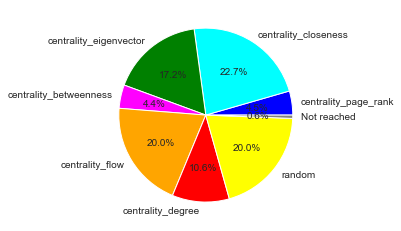

In [8]:
pie_plot(df_final_2, group_list,  time_value=1000)
plt.savefig(r'Visualisations/6_4_pie_2.png', bbox_inches='tight')
plt.show()

In [9]:
results_2 = pair_zscore(df_final_2, time_value=1000)
results_2.pivot(index='x1', columns='x2', values='p_value')

x2,betweenness,closeness,degree,eigenvector,flow,grey,page_rank,random
x1,,,,,,,,
betweenness,NaN,1.0000,1.0000,1.0000,1.0000,0.0,0.5396,1.0000
closeness,0.0000,NaN,0.0000,0.0106,0.1343,0.0,0.0000,0.1493
degree,0.0000,1.0000,NaN,0.9999,1.0000,0.0,0.0000,1.0000
eigenvector,0.0000,0.9894,0.0001,NaN,0.8932,0.0,0.0000,0.8808
flow,0.0000,0.8657,0.0000,0.1068,NaN,0.0,0.0000,0.5043
grey,1.0000,1.0000,1.0000,1.0000,1.0000,NaN,1.0000,1.0000
page_rank,0.4604,1.0000,1.0000,1.0000,1.0000,0.0,NaN,1.0000
random,0.0000,0.8507,0.0000,0.1192,0.4957,0.0,0.0000,NaN
